In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

Path('figures').mkdir(exist_ok=True)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Shared constants
BENCHMARKS = ['HellaSwag', 'ARC-Easy', 'ARC-Challenge', 'WinoGrande', 'MMLU']
TEACHER = {'HellaSwag': 0.526, 'ARC-Easy': 0.831, 'ARC-Challenge': 0.557,
           'WinoGrande': 0.684, 'MMLU': 0.707}

# Best tuned results for main comparison
results = {
    'Teacher (FP16)': [0.526, 0.831, 0.557, 0.684, 0.707],
    'PTQ INT4': [0.509, 0.816, 0.527, 0.674, 0.678],
    'Off-policy (tuned)': [0.517, 0.824, 0.538, 0.688, 0.682],  # λ=0, β=0, lr=5e-6
    'On-policy (tuned)': [0.513, 0.821, 0.531, 0.690, 0.684],   # λ=1, β=1, lr=5e-6
}


def plot_lr_sweep(lrs, train_loss, accuracy, title_suffix='', color='#3498db', save_path=None):
    """Plot LR sweep with train loss (left) and accuracy gap from teacher (right).
    
    Both panels use lower=better convention for easy comparison.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left panel: Train loss vs LR (lower is better)
    ax = axes[0]
    ax.plot(lrs, train_loss, 'o-', color=color, markersize=10, linewidth=2)
    for lr, loss in zip(lrs, train_loss):
        ax.annotate(f'{loss:.3f}', (lr, loss), textcoords='offset points',
                    xytext=(0, -15), ha='center', fontsize=9)
    ax.set_xscale('log')
    ax.set_xlabel('Learning Rate')
    ax.set_ylabel('Final Training Loss (↓ lower is better)')
    ax.set_title(f'Training Loss vs Learning Rate{title_suffix}')
    
    # Right panel: Accuracy gap from teacher (lower is better, 0 = teacher)
    ax = axes[1]
    colors = plt.cm.tab10(np.linspace(0, 0.5, 5))
    for i, (bench, accs) in enumerate(accuracy.items()):
        gap = [(TEACHER[bench] - acc) * 100 for acc in accs]
        ax.plot(lrs, gap, 'o-', label=bench, color=colors[i], markersize=8, linewidth=2)
    ax.set_xscale('log')
    ax.set_xlabel('Learning Rate')
    ax.set_ylabel('Gap from Teacher in pp (↓ lower is better)')
    ax.set_title(f'Accuracy Gap from Teacher{title_suffix}')
    ax.legend(loc='upper left', fontsize=9)
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.7, linewidth=1.5, label='Teacher')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

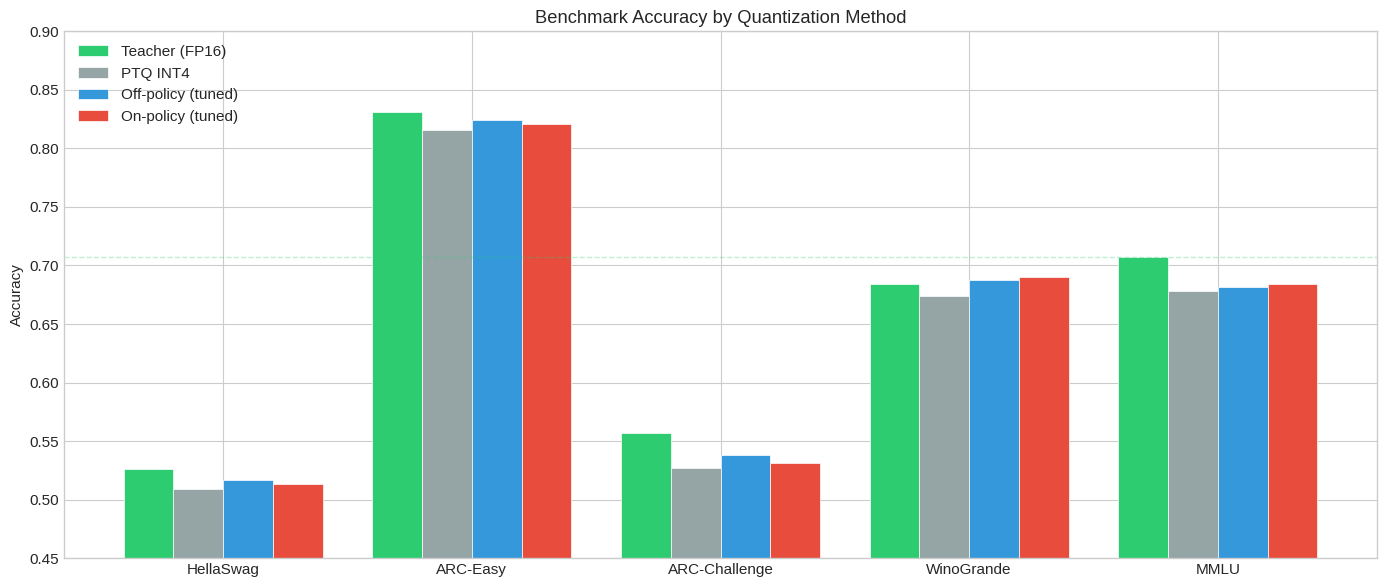

In [2]:
# Main Comparison - Teacher vs PTQ vs Distilled
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(BENCHMARKS))
width = 0.2
colors = ['#2ecc71', '#95a5a6', '#3498db', '#e74c3c']

for i, (model, scores) in enumerate(results.items()):
    ax.bar(x + (i - 1.5) * width, scores, width, label=model, color=colors[i], edgecolor='white', linewidth=0.5)

ax.set_ylabel('Accuracy')
ax.set_title('Benchmark Accuracy by Quantization Method')
ax.set_xticks(x)
ax.set_xticklabels(BENCHMARKS)
ax.legend(loc='upper left')
ax.set_ylim(0.45, 0.9)
ax.axhline(y=0.707, color='#2ecc71', linestyle='--', alpha=0.3, linewidth=1)

plt.tight_layout()
plt.savefig('figures/main_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

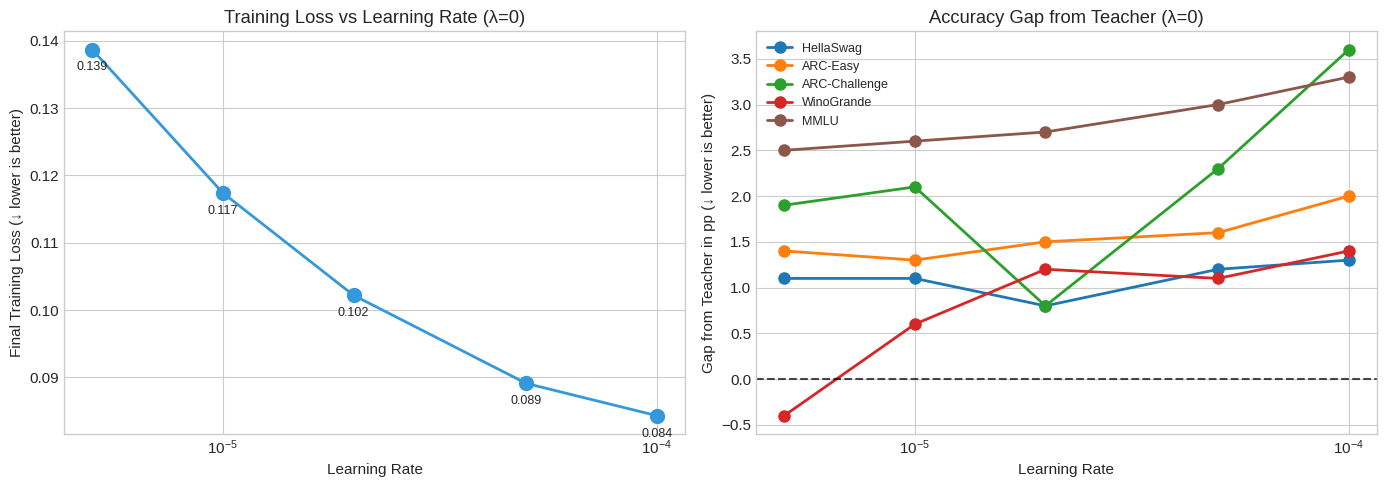

In [3]:
# LR Sweep λ=0 (Off-Policy)
plot_lr_sweep(
    lrs=[5e-6, 1e-5, 2e-5, 5e-5, 1e-4],
    train_loss=[0.1387, 0.1174, 0.1022, 0.0891, 0.0843],
    accuracy={
        'HellaSwag': [0.515, 0.515, 0.518, 0.514, 0.513],
        'ARC-Easy': [0.817, 0.818, 0.816, 0.815, 0.811],
        'ARC-Challenge': [0.538, 0.536, 0.549, 0.534, 0.521],
        'WinoGrande': [0.688, 0.678, 0.672, 0.673, 0.670],
        'MMLU': [0.682, 0.681, 0.680, 0.677, 0.674],
    },
    title_suffix=' (λ=0)',
    color='#3498db',
    save_path='figures/lr_sweep.png'
)

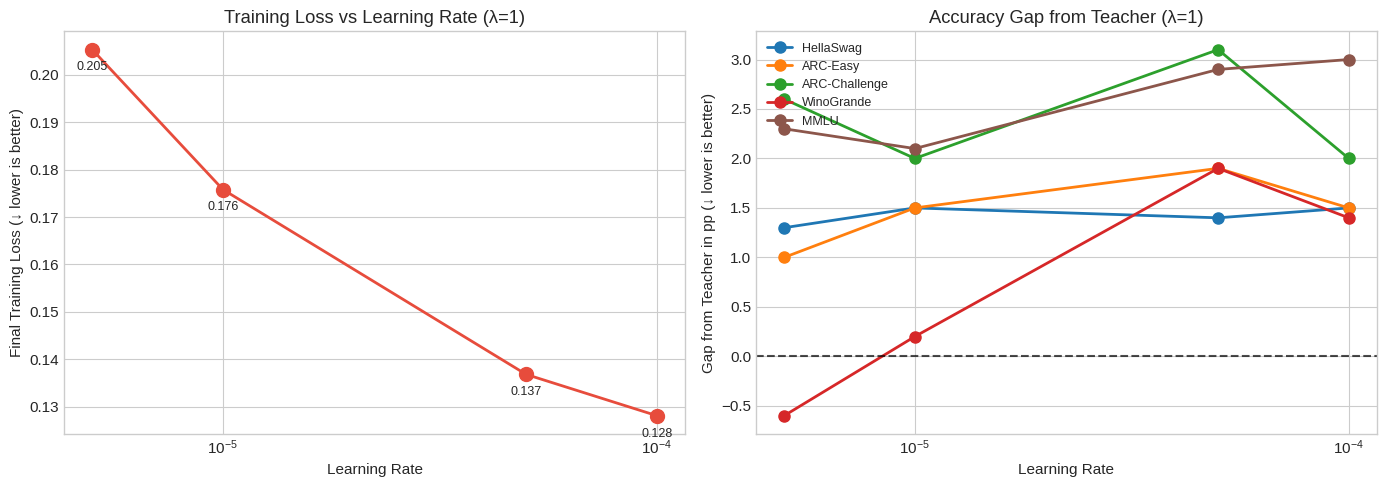

In [4]:
# LR Sweep λ=1 (On-Policy)
plot_lr_sweep(
    lrs=[5e-6, 1e-5, 5e-5, 1e-4],
    train_loss=[0.2053, 0.1758, 0.1368, 0.1281],
    accuracy={
        'HellaSwag': [0.513, 0.511, 0.512, 0.511],
        'ARC-Easy': [0.821, 0.816, 0.812, 0.816],
        'ARC-Challenge': [0.531, 0.537, 0.526, 0.537],
        'WinoGrande': [0.690, 0.682, 0.665, 0.670],
        'MMLU': [0.684, 0.686, 0.678, 0.677],
    },
    title_suffix=' (λ=1)',
    color='#e74c3c',
    save_path='figures/lr_sweep_lmbda1.png'
)